In [29]:
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import matplotlib.pyplot as plt # Научная графика
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier

# **0. Описание задачи**

Цель датасета Bank Marketing — предсказать, подпишет ли клиент банковский срочный вклад (term deposit) после маркетингового телефонного звонка. Это классическая бинарная задача классификации: целевая переменная y принимает значения yes / no (в практике кодируют 1/0). Задача имеет прикладной бизнес-смысл: банк хочет заранее определить клиентов с высокой вероятностью подписки, чтобы оптимизировать кампании и ресурсы.

# **1. Загружаем данные**

In [30]:
url = "https://raw.githubusercontent.com/Akimov52/Machine-Learning/refs/heads/main/bank-additional-full.csv"
data_raw = pd.read_csv(url, sep = ';')

Таблица содержит данные о более 41 тысяч телефонных маркетинговых контактах банка: для каждого контакта сохранена целевая метка — подписал ли клиент срочный вклад (y: yes/no) — и набор признаков: возраст, профессия, семейное положение, образование, наличие просроченных задолженностей (default), есть ли ипотечный (housing) или личный (loan) кредит, тип связи, месяц и день недели звонка, длительность последнего звонка (в секундах), число попыток в текущей кампании (campaign), количество дней, прошедших с момента последнего контакта с клиентом в рамках предыдущей кампании (pdays), количество контактов, выполненных до этой кампании и для этого клиента (previous), результат предыдущей маркетинговой кампании (poutcome), коэффициент изменения занятости (emp.var.rate), индекс потребительских цен (cons.price.idx), индекс потребительской уверенности (cons.conf.idx), ставка Euribor за 3 месяца (euribor3m), количество сотрудников (nr.employed).

Вначале посмотрим на размеры таблицы: количество строк (каждая строка соответствует одному контакту/звонку) и количество столбцов (каждый столбец соответствует конкретному признаку):

In [31]:
data_raw.shape

(41188, 21)

In [32]:
data_raw

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


# **2. Обучающая и тестовая выборки**

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [33]:
# Разделим данные на признаки и целевую переменную
X = data_raw.drop('y', axis=1)
y = data_raw['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(30891, 10297)

# **3. Визуализация данных и вычисление основных характеристик**

Быстрые числовые статистики (среднее значение (mean), стандартное отклонение (std), перцентили (percentiles), коэффициент асимметрии (skew)):

In [34]:
num = data_raw.select_dtypes(include = [np.number])
summary = num.describe().T
summary['skew'] = num.skew()
summary['kurt'] = num.kurtosis()
summary = summary[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurt']]
summary

,count,mean,std,min,25%,50%,75%,max,skew,kurt
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000,0.784697,0.791312
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000,3.263141,20.247938
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000,4.762507,36.979795
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000,-4.922190,22.229463
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000,3.832042,20.108816
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400,-0.724096,-1.062632
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767,-0.230888,-0.829809
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900,0.303180,-0.358558
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045,-0.709188,-1.406803
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100,-1.044262,-0.003760


Распределение целевой и основных числовых признаков:

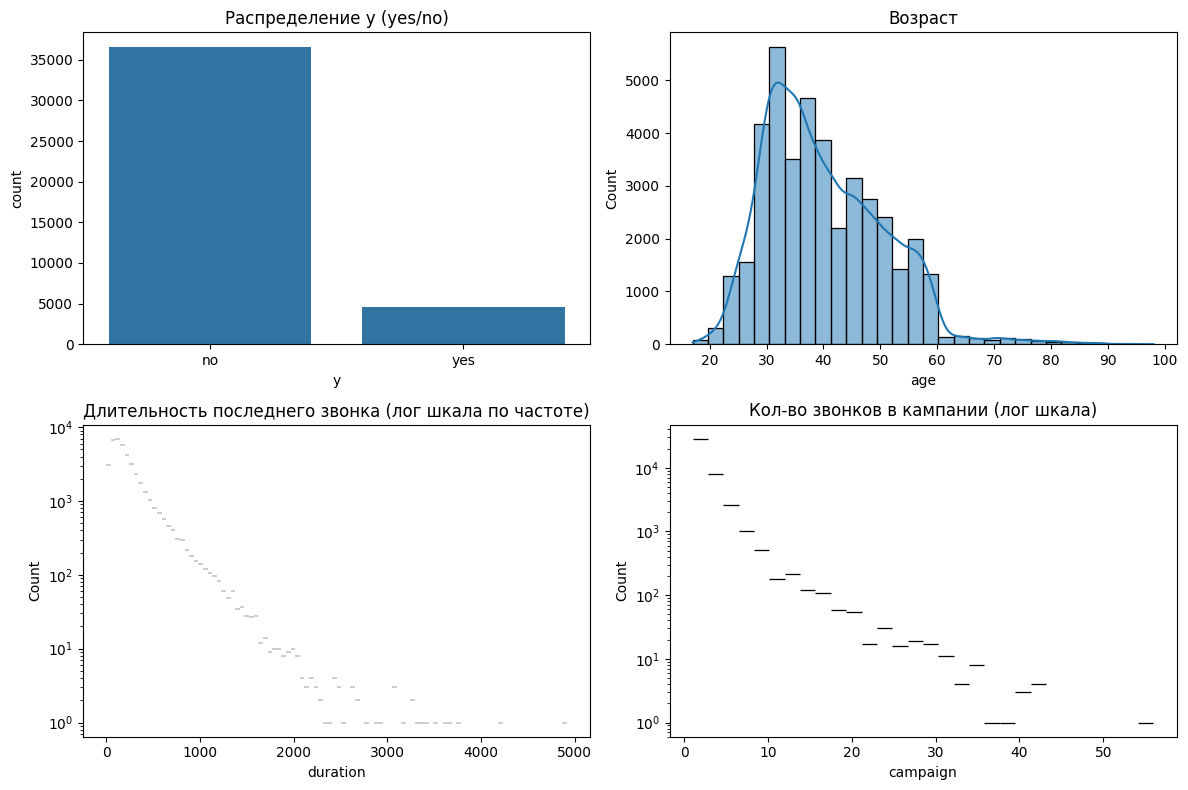

In [35]:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)
sns.countplot(x = 'y', data = data_raw)
plt.title('Распределение y (yes/no)')

plt.subplot(2, 2, 2)
sns.histplot(data_raw['age'].dropna(), bins = 30, kde = True)
plt.title('Возраст')

plt.subplot(2,2,3)
sns.histplot(data_raw['duration'].dropna(), bins = 100, log_scale = (False, True))
plt.title('Длительность последнего звонка (лог шкала по частоте)')

plt.subplot(2, 2, 4)
sns.histplot(data_raw['campaign'].dropna(), bins = 30, log_scale = (False, True))
plt.title('Кол-во звонков в кампании (лог шкала)')

plt.tight_layout()

Частоты категориальных признаков (job, marital, education, contact, poutcome):

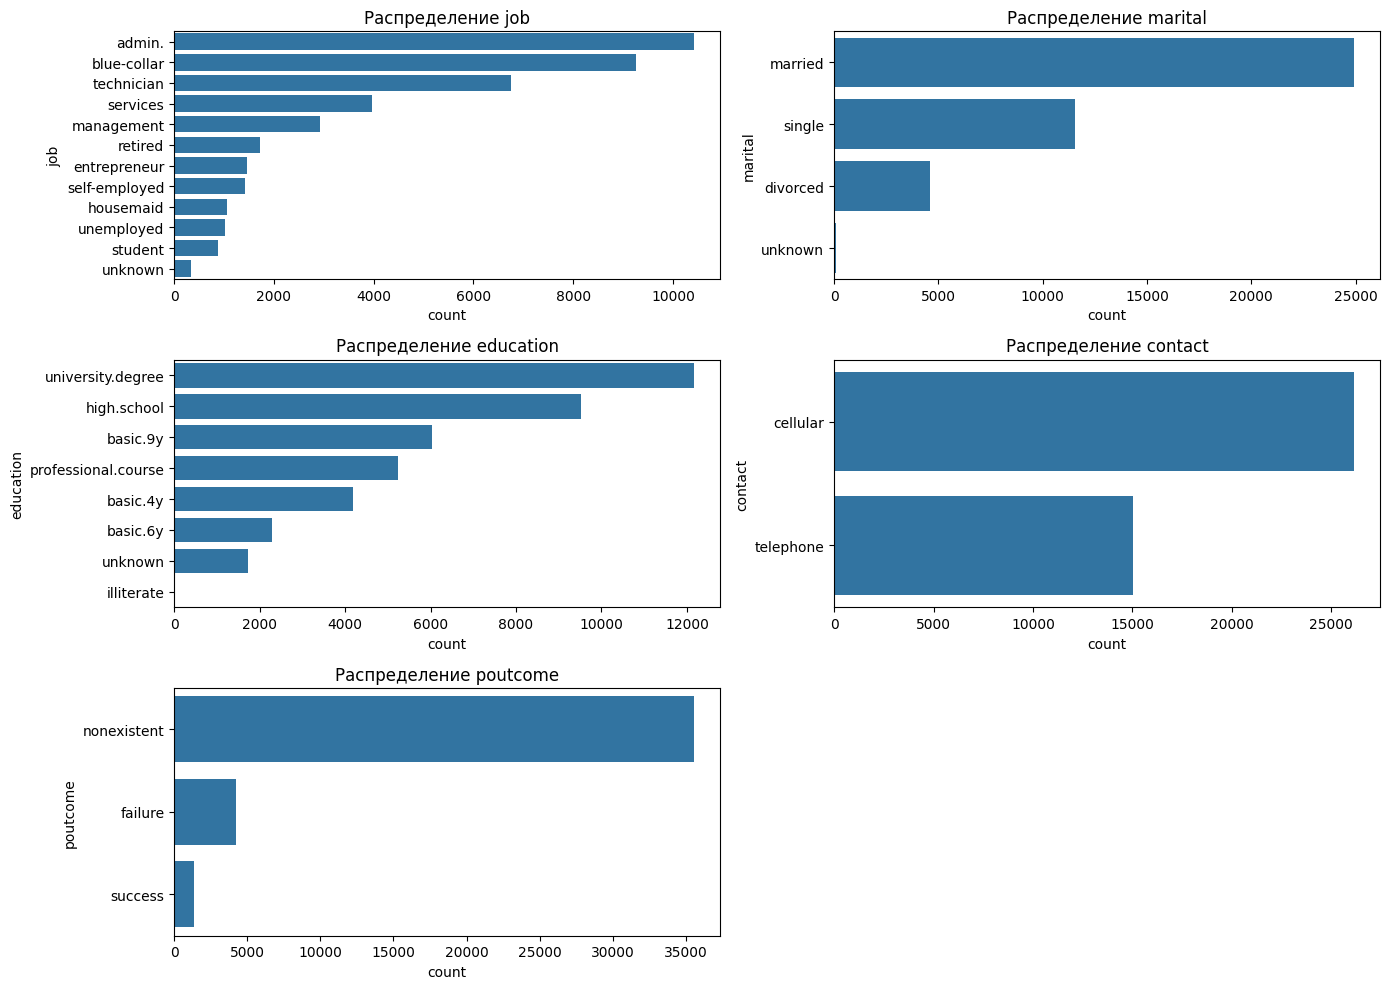

In [36]:
cats = ['job', 'marital', 'education', 'contact', 'poutcome']
plt.figure(figsize = (14, 10))
for i,c in enumerate(cats, 1):
    plt.subplot(3, 2, i)
    order = data_raw[c].value_counts().index
    sns.countplot(y = c, data = data_raw, order = order)
    plt.title(f'Распределение {c}')
plt.tight_layout()

Целевая переменная по ключевым категориям (доля yes):

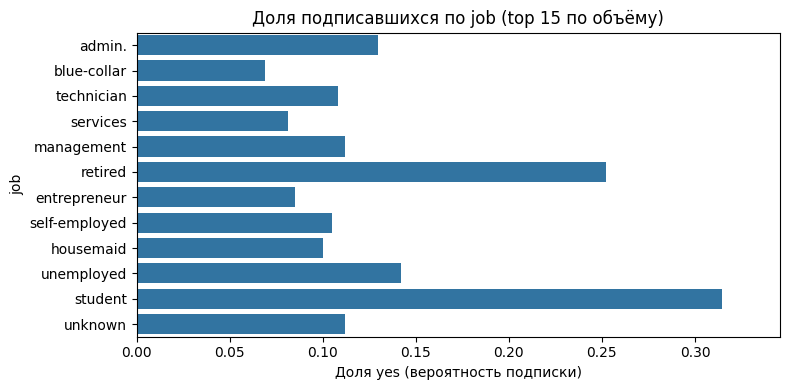

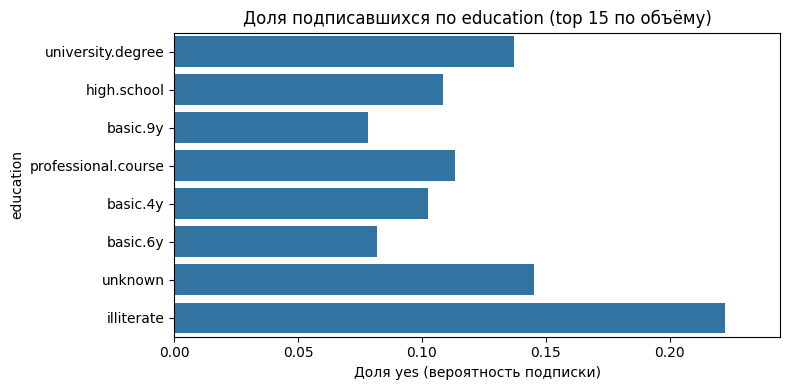

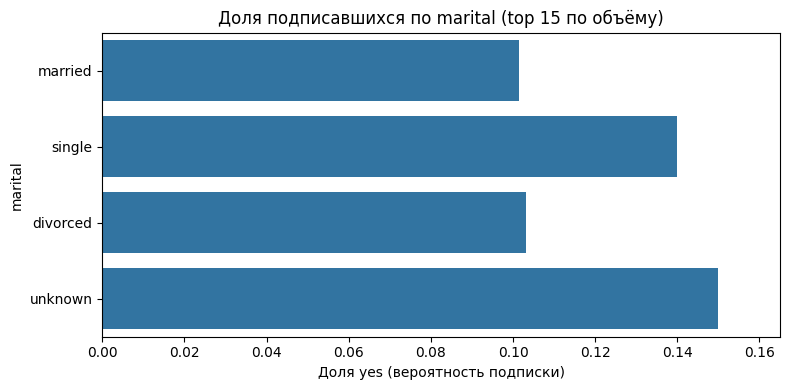

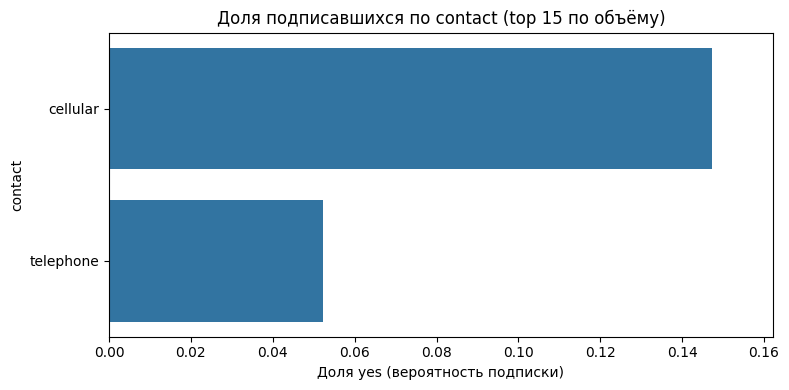

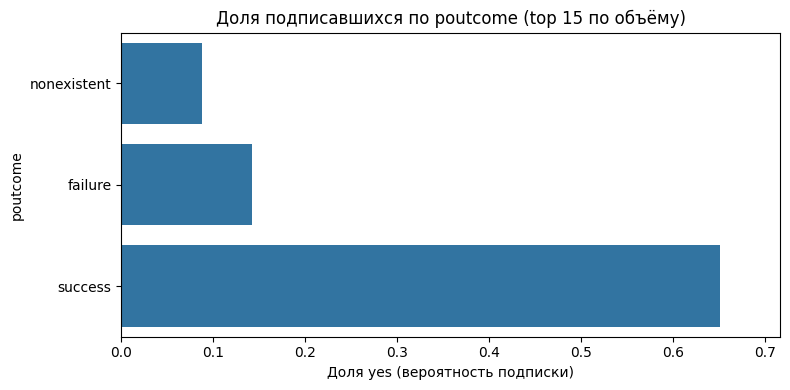

In [37]:
data = data_raw.copy()
data['y_bin'] = data['y'].map({'yes':1,'no':0})

for col in ['job', 'education', 'marital', 'contact', 'poutcome']:
    plt.figure(figsize = (8, 4))
    grp = data.groupby(col)['y_bin'].agg(['mean', 'count']).sort_values('count', ascending = False).head(15)
    grp = grp.reset_index()
    sns.barplot(x = 'mean', y = col, data = grp)
    plt.xlabel('Доля yes (вероятность подписки)')
    plt.title(f'Доля подписавшихся по {col} (top 15 по объёму)')
    plt.xlim(0, grp['mean'].max()*1.1)
    plt.tight_layout()

Cравнение медиан/средних числовых признаков для классов y:

In [38]:
num_cols = data_raw.select_dtypes(include = [np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'y']  # если вдруг y числовой
agg_by_y = data_raw.assign(y_bin = data_raw['y'].map({'yes':1,'no':0})).groupby('y').agg({c:['mean', 'median', 'std'] for c in ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']})
agg_by_y

age                      duration                     campaign  \
          mean median        std        mean median         std      mean   
y                                                                           
no   39.911185   38.0   9.898132  220.844807  163.5  207.096293  2.633085   
yes  40.913147   37.0  13.837476  553.191164  449.0  401.171871  2.051724   

                      previous  ...           emp.var.rate                   \
    median       std      mean  ...       std         mean median       std   
y                               ...                                           
no     2.0  2.873438  0.132374  ...  0.409199     0.248875    1.1  1.482932   
yes    2.0  1.666245  0.492672  ...  0.860344    -1.233448   -1.8  1.623626   

    euribor3m                   nr.employed                     
         mean median       std         mean  median        std  
y                                                               
no   3.811491  4.857  1.638187  5176.166600  5195.8  64.571979  
yes  2.123135  1.266  1.742598  5095.115991  5099.1  87.572641  

[2 rows x 21 columns]

Корреляционная матрица числовых признаков + корреляция с целевой:

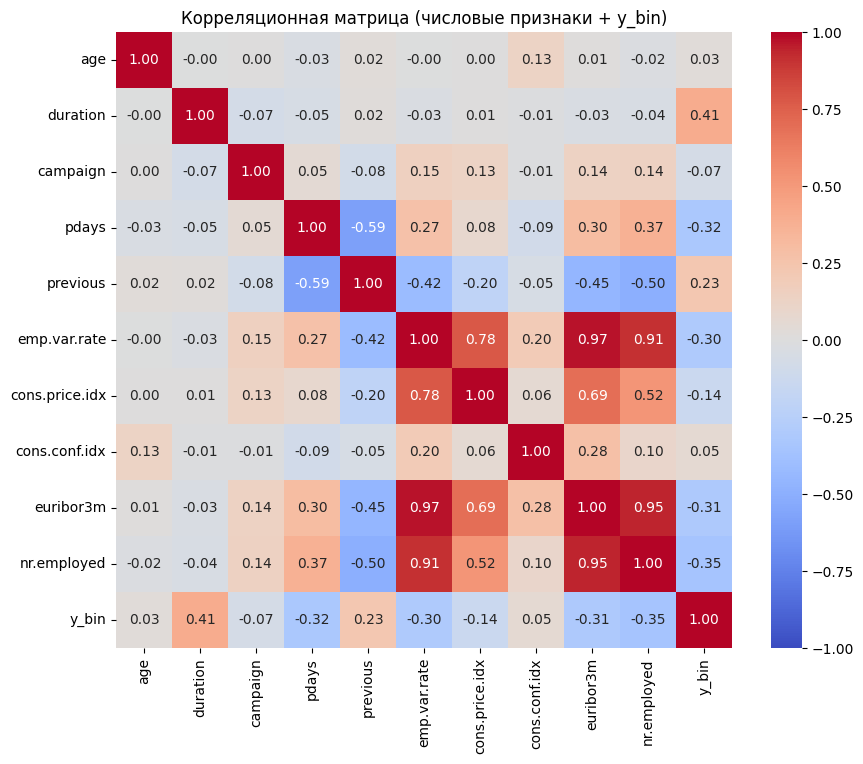

Корреляции по модулю с y (в порядке убывания):


,y_bin
duration,0.405274
nr.employed,0.354678
pdays,0.324914
euribor3m,0.307771
emp.var.rate,0.298334
previous,0.230181
cons.price.idx,0.136211
campaign,0.066357
cons.conf.idx,0.054878
age,0.030399


In [39]:
num = data_raw.select_dtypes(include = [np.number]).copy()
# Добавляем бинарную y для корреляции
num['y_bin'] = data_raw['y'].map({'yes':1,'no':0})
corr = num.corr()
plt.figure(figsize = (10, 8))
sns.heatmap(corr, square=True, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Корреляционная матрица (числовые признаки + y_bin)')
plt.show()

# Выведем топ корреляций с y
corr_with_y = corr['y_bin'].drop('y_bin').abs().sort_values(ascending = False)
print("Корреляции по модулю с y (в порядке убывания):")
display(corr_with_y)

Scatter/box для важных связей (duration vs y, euribor3m vs y):

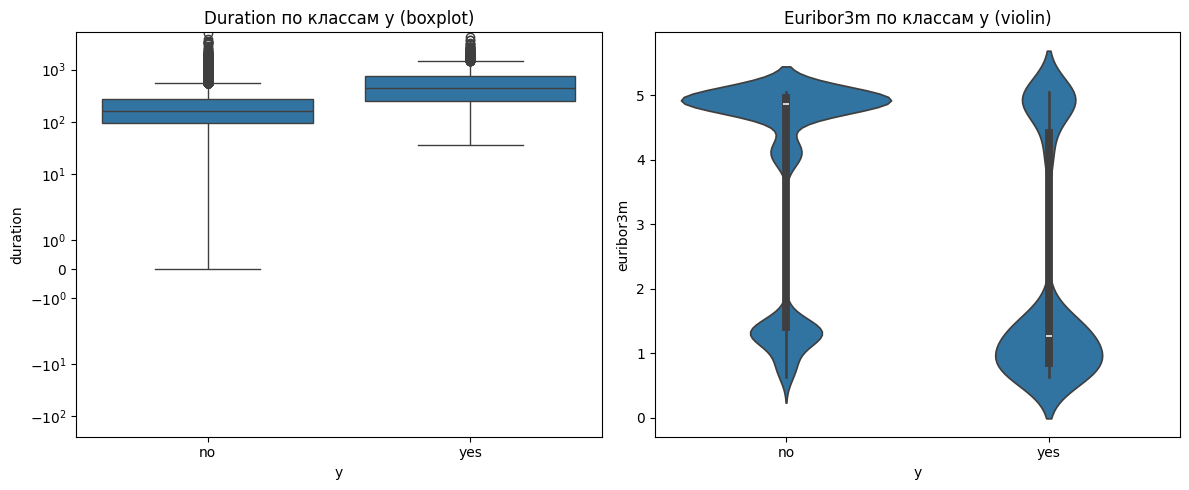

In [40]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x = data_raw['y'], y = data_raw['duration'])
plt.yscale('symlog')
plt.title('Duration по классам y (boxplot)')

plt.subplot(1, 2, 2)
sns.violinplot(x = data_raw['y'], y = data_raw['euribor3m'])
plt.title('Euribor3m по классам y (violin)')
plt.tight_layout()
plt.show()

Текстовые агрегаты: pct missing, unknown counts, базовые groupby:

In [41]:
missing = data_raw.isnull().sum().sort_values(ascending = False)
print("Пропуски по столбцам:")
display(missing[missing > 0])

# 'unknown' в категориальных
cat_cols = data_raw.select_dtypes(include = ['object']).columns.tolist()
unknown_counts = {c: int((data_raw[c].astype(str).str.lower() == 'unknown').sum()) for c in cat_cols}
print("Число 'unknown' по категориальным признакам:")
display(pd.Series(unknown_counts).sort_values(ascending = False))

# Средняя доля yes по месяцам
m = data_raw.copy()
m['y_bin'] = m['y'].map({'yes':1,'no':0})
print("Доля подписавшихся по месяцам (месяц):")
display(m.groupby('month')['y_bin'].agg(['mean', 'count']).sort_values('count', ascending = False))

Пропуски по столбцам:


,0


Число 'unknown' по категориальным признакам:


,0
default,8597
education,1731
housing,990
loan,990
job,330
marital,80
contact,0
month,0
day_of_week,0
poutcome,0


Доля подписавшихся по месяцам (месяц):


,mean,count
month,,
may,0.064347,13769
jul,0.090466,7174
aug,0.106021,6178
jun,0.105115,5318
nov,0.101439,4101
apr,0.204787,2632
oct,0.438719,718
sep,0.449123,570
mar,0.505495,546


# **4. Обработка пропущенных значений**

In [42]:
from sklearn.impute import SimpleImputer

# Копируем исходные train/test данные
Xtr = X_train.copy()
Xte = X_test.copy()

# Определяем числовые и категориальные колонки
num_cols = Xtr.select_dtypes(include = [np.number]).columns.tolist()
cat_cols = Xtr.select_dtypes(include = ['object']).columns.tolist()

# Заменяем 'unknown' на np.nan в категориальных признаках
for c in cat_cols:
    Xtr[c] = Xtr[c].replace('unknown', np.nan)
    Xte[c] = Xte[c].replace('unknown', np.nan)

# Создаем импьютеры
num_imp = SimpleImputer(strategy = 'median')          # для числовых
cat_imp = SimpleImputer(strategy = 'most_frequent')   # для категориальных

# Импутируем числовые признаки (обучаем на train, применяем к test)
Xtr_num_imp = pd.DataFrame(num_imp.fit_transform(Xtr[num_cols]), columns = num_cols, index = Xtr.index)
Xte_num_imp = pd.DataFrame(num_imp.transform(Xte[num_cols]), columns = num_cols, index = Xte.index)

# Импутируем категориальные признаки (обучаем на train, применяем к test)
Xtr_cat_imp = pd.DataFrame(cat_imp.fit_transform(Xtr[cat_cols]), columns = cat_cols, index = Xtr.index)
Xte_cat_imp = pd.DataFrame(cat_imp.transform(Xte[cat_cols]), columns = cat_cols, index = Xte.index)

# Собираем обратно таблицы с теми же колонками и порядком
X_train_imp = pd.concat([Xtr_num_imp, Xtr_cat_imp], axis=1)[X_train.columns]
X_test_imp  = pd.concat([Xte_num_imp, Xte_cat_imp], axis=1)[X_test.columns]

print("\nРазмеры обработанных выборок:")
print("X_train_imp:", X_train_imp.shape)
print("X_test_imp:", X_test_imp.shape)

print("\nПример данных после обработки:")
display(X_train_imp.head())


Размеры обработанных выборок:
X_train_imp: (30891, 20)
X_test_imp: (10297, 20)

Пример данных после обработки:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
549,50.0,blue-collar,married,basic.4y,no,yes,no,telephone,may,tue,153.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1974,26.0,blue-collar,single,high.school,no,no,no,telephone,may,fri,213.0,4.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
20992,34.0,technician,married,high.school,no,yes,no,cellular,aug,thu,85.0,3.0,999.0,0.0,nonexistent,1.4,93.444,-36.1,4.964,5228.1
1730,30.0,blue-collar,single,basic.9y,no,yes,no,telephone,may,fri,322.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
26913,29.0,admin.,single,university.degree,no,yes,no,cellular,nov,thu,341.0,2.0,999.0,0.0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8


# **5. Обработка категориальных признаков**

In [43]:
from sklearn.preprocessing import OneHotEncoder

# Определим числовые и категориальные колонки заново на основе импутированных таблиц
num_cols = X_train_imp.select_dtypes(include = [np.number]).columns.tolist()
cat_cols = X_train_imp.select_dtypes(include = ['object', 'category']).columns.tolist()

print("Числовые признаки:", len(num_cols), num_cols)
print("Категориальные признаки:", len(cat_cols), cat_cols)

# Создаём OHE (handle_unknown = 'ignore', sparse_output = False для получения numpy array)
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)

# Обучаем OHE на train и трансформируем train/test
Xtr_cat_ohe = pd.DataFrame(ohe.fit_transform(X_train_imp[cat_cols]), columns = ohe.get_feature_names_out(cat_cols), index = X_train_imp.index)

Xte_cat_ohe = pd.DataFrame(ohe.transform(X_test_imp[cat_cols]), columns = ohe.get_feature_names_out(cat_cols), index = X_test_imp.index)

# Собираем окончательные закодированные датасеты (числовые + OHE-категории)
X_train_enc = pd.concat([X_train_imp[num_cols], Xtr_cat_ohe], axis=1)
X_test_enc  = pd.concat([X_test_imp[num_cols],  Xte_cat_ohe ], axis=1)

print("\nРазмеры после кодирования:")
print("X_train_enc:", X_train_enc.shape)
print("X_test_enc: ", X_test_enc.shape)

print("\nЧасть новых имен признаков (OHE):")
display(list(Xtr_cat_ohe.columns)[:40])  # первые 40 OHE-признаков

print("\nПримеры строк после кодирования:")
display(X_train_enc.head())

Числовые признаки: 10 ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Категориальные признаки: 10 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Размеры после кодирования:
X_train_enc: (30891, 57)
X_test_enc:  (10297, 57)

Часть новых имен признаков (OHE):


['job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_basic.4y',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'default_no',
 'default_yes',
 'housing_no',
 'housing_yes',
 'loan_no',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_fri']


Примеры строк после кодирования:


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
549,50.0,153.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1974,26.0,213.0,4.0,999.0,0.0,1.1,93.994,-36.4,4.855,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20992,34.0,85.0,3.0,999.0,0.0,1.4,93.444,-36.1,4.964,5228.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1730,30.0,322.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.855,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26913,29.0,341.0,2.0,999.0,0.0,-0.1,93.200,-42.0,4.076,5195.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# **6. Нормализация**

В нашем случае нормализация не требуется, так как:
1. Мы решаем задачу классификации, а не регрессии. Целевая переменная y — категориальная (yes / no), и модель будет предсказывать класс, а не численное значение.
2. Большинство признаков в наборе Bank Marketing являются категориальными (например, job, marital, education, contact, month, day_of_week, poutcome). Они были закодированы с помощью OneHotEncoding, и такие бинарные признаки уже находятся в одинаковом масштабе (0 или 1).

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# делаем копии
X_train_scaled = X_train_enc.copy()
X_test_scaled  = X_test_enc.copy()

# масштабируем ТОЛЬКО числовые колонки исходного списка num_cols
X_train_scaled[num_cols] = scaler.fit_transform(X_train_enc[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test_enc[num_cols])

print("Размеры:", X_train_scaled.shape, X_test_scaled.shape)
display(X_train_scaled.head())

Размеры: (30891, 57) (10297, 57)


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
549,0.955475,-0.403103,-0.570952,0.193869,-0.350094,0.647305,0.719420,0.887039,0.711733,0.330697,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1974,-1.341636,-0.171771,0.520847,0.193869,-0.350094,0.647305,0.719420,0.887039,0.710580,0.330697,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20992,-0.575932,-0.665280,0.156914,0.193869,-0.350094,0.838301,-0.229963,0.951837,0.773427,0.842704,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1730,-0.958784,0.248483,-0.570952,0.193869,-0.350094,0.647305,0.719420,0.887039,0.710580,0.330697,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26913,-1.054497,0.321738,-0.207019,0.193869,-0.350094,-0.116675,-0.651144,-0.322526,0.261424,0.396941,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# **7. Классификатор Random Forest**

RandomForest — рекомендуемый выбор для Bank Marketing: хорошо работает с разрежёнными OHE-признаками, не требует масштабирования, устойчив к выбросам, умеет учитывать несбалансированность через class_weight, даёт важности признаков для интерпретации и быстро обучается в сравнении с KNN на больших данных.

Числовых: 10 ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Категориальных: 10 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
=== Train ===
              precision    recall  f1-score   support

          no     1.0000    1.0000    1.0000     27404
         yes     1.0000    1.0000    1.0000      3487

    accuracy                         1.0000     30891
   macro avg     1.0000    1.0000    1.0000     30891
weighted avg     1.0000    1.0000    1.0000     30891

=== Test ===
              precision    recall  f1-score   support

          no     0.9287    0.9751    0.9513      9144
         yes     0.6729    0.4068    0.5070      1153

    accuracy                         0.9114     10297
   macro avg     0.8008    0.6909    0.7292     10297
weighted avg     0.9001    0.9114    0.9016     10297

ROC AUC (test): 0.941531477851912
PR AUC  (tes

,Pred no,Pred yes
Actual no,8916,228
Actual yes,684,469



Top-30 feature importances:


,0
duration,0.357316
euribor3m,0.087019
nr.employed,0.057575
age,0.056670
emp.var.rate,0.051631
cons.conf.idx,0.033934
campaign,0.030025
cons.price.idx,0.024918
pdays,0.018506
month_may,0.011603


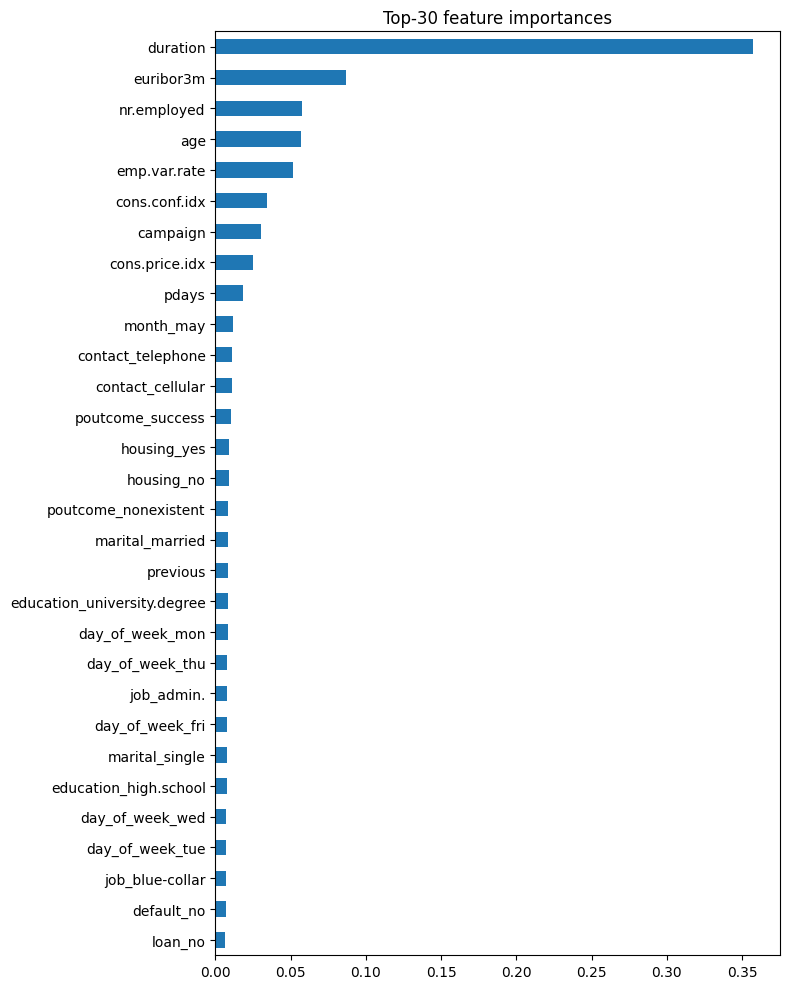

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Определим списки признаков на основе X_train
num_cols = X_train.select_dtypes(include = [np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include = ['object', 'category']).columns.tolist()

print("Числовых:", len(num_cols), num_cols)
print("Категориальных:", len(cat_cols), cat_cols)

# Preprocessor: числовые -> median, категориальные -> most_frequent + OHE
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median'))])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')), ('ohe', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))])

preprocessor = ColumnTransformer([('num', num_pipeline, num_cols), ('cat', cat_pipeline, cat_cols)], remainder = 'drop', sparse_threshold=0)

# Pipeline с RandomForest
rf_pipe = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators = 200, random_state = 42, class_weight = 'balanced', n_jobs = -1))])

# Обучение
rf_pipe.fit(X_train, y_train)

# Предсказания
y_train_pred = rf_pipe.predict(X_train)
y_test_pred  = rf_pipe.predict(X_test)
y_test_bin = y_test.map({'yes':1,'no':0}) if y_test.dtype == object else y_test
y_proba = rf_pipe.predict_proba(X_test)[:,1]

# Отчёты
print("=== Train ===")
print(classification_report(y_train, y_train_pred, digits = 4))
print("=== Test ===")
print(classification_report(y_test, y_test_pred, digits = 4))
print("ROC AUC (test):", roc_auc_score(y_test_bin, y_proba))
print("PR AUC  (test):", average_precision_score(y_test_bin, y_proba))

print("Confusion matrix (test):")
display(pd.DataFrame(confusion_matrix(y_test, y_test_pred), index = ['Actual no', 'Actual yes'], columns = ['Pred no', 'Pred yes']))

# Feature importances (получаем имена признаков после трансформации)
pre = rf_pipe.named_steps['pre']
ohe = pre.named_transformers_['cat'].named_steps['ohe']
ohe_feats = list(ohe.get_feature_names_out(cat_cols))
feature_names = num_cols + ohe_feats
fi = pd.Series(rf_pipe.named_steps['clf'].feature_importances_, index = feature_names).sort_values(ascending = False)
print("\nTop-30 feature importances:")
display(fi.head(30))
fi.head(30).sort_values().plot.barh(figsize = (8, 10))
plt.title('Top-30 feature importances')
plt.tight_layout()
plt.show()

# **8. Вычисление ошибок на обучающей и тестовой выборках**

Точность на обучающей выборке: 1.0000
Точность на тестовой выборке:  0.9114

Матрица рассогласования (обучающая выборка):


,Pred no,Pred yes
Actual no,27404,0
Actual yes,0,3487



Матрица рассогласования (тестовая выборка):


,Pred no,Pred yes
Actual no,8916,228
Actual yes,684,469


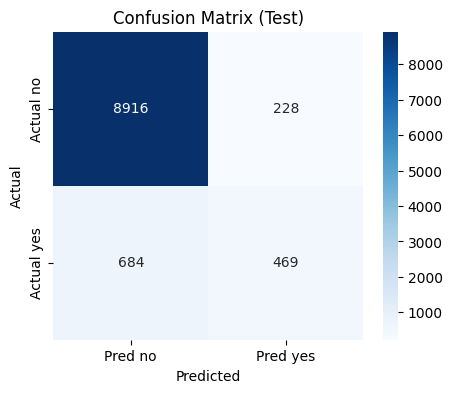

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Предсказания
y_train_pred = rf_pipe.predict(X_train)
y_test_pred  = rf_pipe.predict(X_test)

# Ошибки (точность)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print(f"Точность на обучающей выборке: {train_acc:.4f}")
print(f"Точность на тестовой выборке:  {test_acc:.4f}")

# Матрицы рассогласования
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test  = confusion_matrix(y_test,  y_test_pred)

print("\nМатрица рассогласования (обучающая выборка):")
display(pd.DataFrame(cm_train, index = ['Actual no', 'Actual yes'], columns = ['Pred no', 'Pred yes']))

print("\nМатрица рассогласования (тестовая выборка):")
display(pd.DataFrame(cm_test, index = ['Actual no', 'Actual yes'], columns = ['Pred no', 'Pred yes']))

# График для теста
plt.figure(figsize = (5, 4))
sns.heatmap(cm_test, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Pred no', 'Pred yes'], yticklabels=['Actual no', 'Actual yes'])
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Метрики качества**  
Точность на обучающей выборке: 1.0000   
Точность на тестовой выборке: 0.9114  
Это классическая картина переобучения (overfitting) для RandomForest:
модель идеально выучила обучающую выборку, но на тесте потеряла около 9 % точности.

**Анализ матриц рассогласования**  
True Negatives (8916) — корректно предсказанные "no" (основной, доминирующий класс).  
False Positives (228) — предсказали "yes", но реально "no".   
False Negatives (684) — предсказали "no", но реально "yes" → это ошибки второго рода, где модель не заметила потенциального положительного клиента.   
True Positives (469) — корректно предсказанные "yes".

**Вывод по качеству**  
Модель очень хорошо различает основной класс ("no"), но немного теряет на редком классе ("yes").  
Несмотря на небольшое смещение, точность 0.91 на тесте — высокий результат.   
Основное ограничение — переобучение: 100 % на train указывает на то, что деревья были слишком глубокие.

# **9. Общие выводы**

В ходе работы была решена задача бинарной классификации — определение, согласится ли клиент банка на оформление срочного депозита на основе данных телефонных маркетинговых кампаний.   
Датасет содержал более 40 тысяч наблюдений и 20 признаков, включающих социально-демографические характеристики клиента (возраст, семейное положение, профессия), параметры контакта (месяц, день недели, длительность звонка, количество предыдущих попыток) и макроэкономические показатели.